# Train an augmented simulator (Power Grid use case)

This notebook shows how to select and train an augmented simulator. In this notebook, we concentrate on the already implemented architectures. 

We will also show how the trained augmented simulators could be stored and be restored in future for the evaluation (for the evaluation see Notebook 2). As the training of an augmented simulator could be costly, we suggest users to use a GPU ressource if available and also to store their model for its further evaluation.

We use the `Benchmark1` and the `Benchmark2` of the Power Grid use case to demonstrate how to perform this task. 

On the first section, we explain how to use a model that is already available on this reposotiry. The second section is dedicated to the explanation of what is needed to create a different kind of `AugmentedSimulator` with a different Neural Network archiecture with a customized loss etc.

## TOC:
* [Benchmark1](#benchmark1)
    * [FullyConnected](#fc_benchmark1)
    * [LeapNet](#leapnet_benchmark1)
* [Benchmark2](#benchmark2)
    * [FullyConnected](#fc_benchmark2)
    * [LeapNet](#leapnet_benchmark2)
* [Code another `augmented simulator`](#code-another)

In [ ]:
import pathlib
from pprint import pprint
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.utils import get_path

In [ ]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_MODEL_PATH = LIPS_PATH / "trained_models" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

# Benchmark1 <a class="anchor" id="benchmark1"></a>

## Load the benchmark dataset

As always the first step is always to load our dataset.

In [ ]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

To verify the config is loaded appropriately for this benchmark

In [ ]:
print("Benchmark name: ", benchmark1.config.section_name)
print("Environment name: ", benchmark1.config.get_option("env_name"))
print("Output attributes: ", benchmark1.config.get_option("attr_y"))
print("Evaluation criteria: ")
pprint(benchmark1.config.get_option("eval_dict"))

## Train an available model (Fully Connected) <a class="anchor" id="fc_benchmark1"></a>

In this section we explain how to tune an available model. We take the example of the `FullyConnectedAS` that is an available fully connected neural network.

This section supposes that you already have a "model" (for example based on neural networks) that meets the `AugmentedSimulator` interface. If you do not have it already, the next section will cover the main principles.

**NB** The creation of the 'augmented_simulator' depends on each type of 'augmented_simulator'. 

The first step is to create the class you want to use, with the meta parameters you want to test. For this example:

In [ ]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)
    
tf_fc = TfFullyConnected(name="tf_fc",
                         # the path to the augmented simulator config file containing its hyperparameters
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         # using a specific configuration available in configuration file, DEFAULT here
                         sim_config_name="DEFAULT",
                         # the path to the benchmark config file
                         bench_config_path=BENCH_CONFIG_PATH,
                         # `Benchmark_name` should correspond to one of config sections created earlier
                         bench_config_name="Benchmark1",
                         # use a scaler class used to scale the datasets for a better learning
                         scaler=StandardScaler,
                         # a path where the logs during the training should be stored for debugging purpose
                         log_path=LOG_PATH)

Then you need to train it. For example here we will train it for 200 epochs.

**NB** You are responsible to use the correct dataset for training your model ! You can make experiments by training on the `test` set or on the `test_ood_topo` set if you want but we don't recommend you do to so !

**NB** This code is generic and should work for all `AugementedSimulator`

In [ ]:
tf_fc.train(train_dataset=benchmark1.train_dataset,
            val_dataset=benchmark1.val_dataset,
            epochs=100
           )

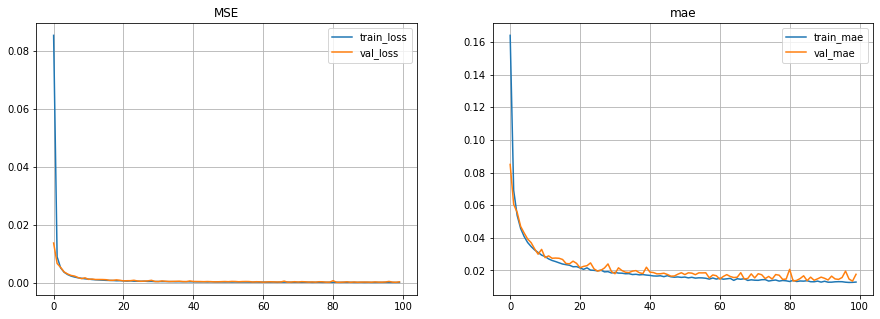

In [15]:
tf_fc.visualize_convergence()

And then you can save it:

In [ ]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark1)
tf_fc.save(SAVE_PATH)

Once saved, if you want to reuse it you can do exactly as we did in the previous notebook:
```python
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

tf_fc = TfFullyConnected(name="tf_fc", # the name should match!
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark1",
                         scaler=StandardScaler,
                         log_path=LOG_PATH) 

LOAD_PATH = get_path(BASELINES_PATH, benchmark1)
tf_fc.restore(LOAD_PATH)
```

And you are good to go !

## Train another architecture (LeapNet model) <a class="anchor" id="leapnet_benchmark1"></a>
The leap nets allows to take into account the topology in the latent space, and have a more robust generalization performance than a simple fully connected model.

In [ ]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler import PowerGridScaler

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)

In [ ]:
leap_net = LeapNet(name="tf_leapnet",
                   # The path to the augmented simulator config file. It contains all the required hyperparameters
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT",
                   # the path to Benchmark config file
                   bench_config_path=BENCH_CONFIG_PATH,
                   # `Benchmark_name` should correspond to one of config sections created earlier
                   bench_config_name="Benchmark1",
                   # We can indeed override the hyperparameters considered in the config file directly by assigning the corresponding arguments
                   sizes_main=(150, 150), # we change the number of the layers and the neurons in the main part
                   sizes_enc=(20, 20, 20), # changing the number of the layers and neurones in encoding part
                   sizes_out=(100, 40), # changing the number of the layers and neurones in decoding part
                   # A scaler should be used to normalize the data. Here, we use a specific scaler for power grid data
                   scaler=PowerGridScaler, 
                   # A path where the logs should be stored for debugging purpose
                   log_path=LOG_PATH)

### Train the model 

In [ ]:
leap_net.train(train_dataset=benchmark1.train_dataset,
               val_dataset=benchmark1.val_dataset,
               epochs=200
              )

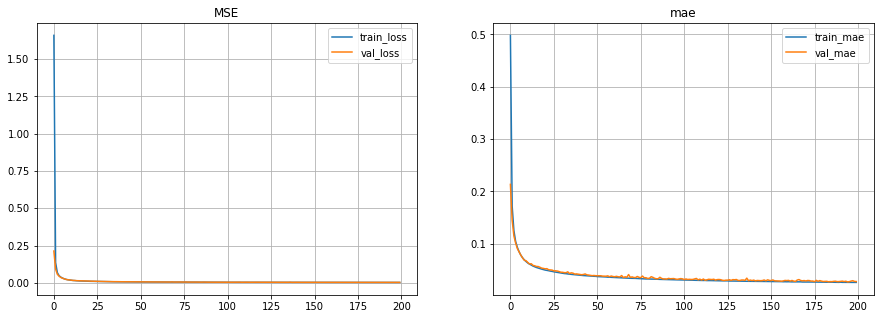

In [31]:
leap_net.visualize_convergence()

And then you can save it:

In [ ]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark1)
leap_net.save(SAVE_PATH)

# Benchmark2 <a class="anchor" id="benchmark2"></a>
The same procedure in benchmark1 can be applied without any exception to other benchmarks. The only difference resides in the instantiating of the benchmark class which provides the required datasets for this specific benchmark (`Benchmark2`). 

In [ ]:
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

To verify the config is loaded appropriately for this benchmark. As we have seen in Notebook 0, there are more evaluation criteria for this more complex benchmark, as the augmented simulators are supposed to predict more flow variables. 

In [ ]:
print("Benchmark name: ", benchmark2.config.section_name)
print("Environment name: ", benchmark2.config.get_option("env_name"))
print("Output attributes: ", benchmark2.config.get_option("attr_y"))
print("Evaluation criteria: ")
pprint(benchmark2.config.get_option("eval_dict"))

## Fully Connected model <a class="anchor" id="fc_benchmark2"></a>

In [ ]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)

# rebuild the baseline architecture
tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark2",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

In [ ]:
tf_fc.train(train_dataset=benchmark2.train_dataset, val_dataset=benchmark2.val_dataset, epochs=200)

Visalize the convergence curves of the model. It comprises two curves which are based on the Loss metric on the basis of which the model is trained (Mean Squared Error `MSE`) and also a metric that is computed alongside the loss criteria (Mean Absolute Error `MAE`).

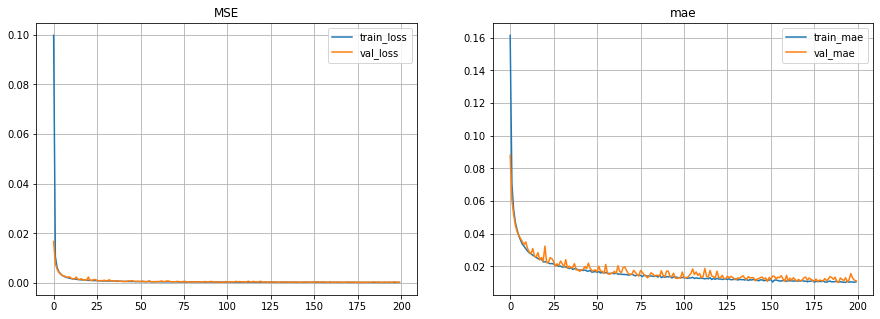

In [11]:
tf_fc.visualize_convergence()

And then you can save it:

In [ ]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark2)
tf_fc.save(SAVE_PATH)

## LeapNet model <a class="anchor" id="leapnet_benchmark2"></a>

In [ ]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler import PowerGridScaler

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)

In [ ]:
leap_net = LeapNet(name="tf_leapnet",
                   # The path to the augmented simulator config file. It contains all the required hyperparameters
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT",
                   # the path to Benchmark config file
                   bench_config_path=BENCH_CONFIG_PATH,
                   # `Benchmark_name` should correspond to one of config sections created earlier
                   bench_config_name="Benchmark2",
                   # We can indeed override the hyperparameters considered in the config file directly by assigning the corresponding arguments
                   sizes_main=(150, 150), # we change the number of the layers and the neurons in the main part
                   sizes_enc=(20, 20, 20), # changing the number of the layers and neurones in encoding part
                   sizes_out=(100, 40), # changing the number of the layers and neurones in decoding part
                   # A scaler should be used to normalize the data. Here, we use a specific scaler for power grid data
                   scaler=PowerGridScaler, 
                   # A path where the logs should be stored for debugging purpose
                   log_path=LOG_PATH)

### Train the model 

In [ ]:
leap_net.train(train_dataset=benchmark2.train_dataset,
               val_dataset=benchmark2.val_dataset,
               epochs=200
              )

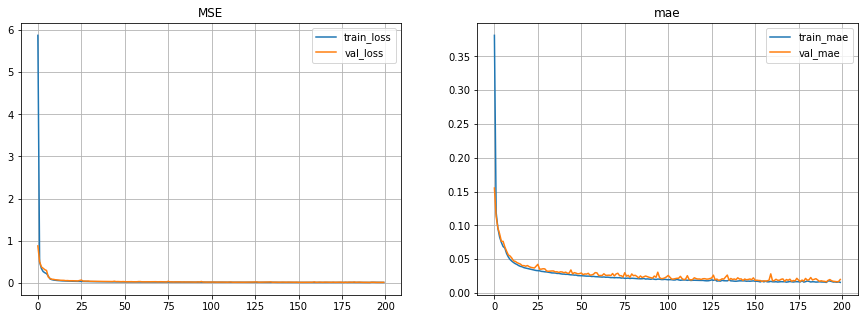

In [44]:
leap_net.visualize_convergence()

And then you can save it:

In [ ]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark2)
leap_net.save(SAVE_PATH)

# Code another type of "augmented_simulator" <a id="code-another"></a>

In our framework, we have provided the implementations of augmented simulators based on `Tensorflow` and `Pytorch` libraries following the class diagram shown below.  

![title](img/ClassDiagramAS.png)

For now, we have provided two augmented simulators based on Tensorflow, namely `FullyConnected` and `LeapNet` architectures, and one augmented simulator (`FullyConnected`) using Pytorch library as a starting point for users familiar with Pytorch. 

For each of these libraries, we provide also a controller (base class) which provide the main functionalities to train and evaluate the augmented simulators. So the users could focus only on the interesting part which is the construction of an augmented simulator architecture. 

Coding another type of "augmented simulator" is not difficult. Finding one that work well for all the criteria is of course a different challenge.

### Tensorflow
Basically, an augmented simulator based on `TensorFlow` should:

- inherit from `TensorflowSimulator`
- implements the `build_model` where the architecture is defined
- implements the `process_data` which prepare and scale the data for the specific augmented simulator
- implementes the `_infer_size`, `_post_process` to infer the data dimensions and to post process the predictions (inverse scaling to find the original values)
- implements `_save_metadata` and `_load_metadata` to save and load all the specific metadata of the implemented model

More information is given on the documentation. And a fully working example is given in the `TfFullyConnected` class.


### Pytorch
For an augmented simulator based on `Pytorch`, the only difference resides in the first step where you can directly use pytorch logic, however, the remaining steps remains very similar:

- Inherit from `torch.nn.Module`
- Implements `build_model` to defin the architecture
- Implements `forward` to define the interaction between modules
- Implements `process_data`  which prepare and scale the data for the specific augmented simulator
- implementes the `_infer_size`, `_post_process` to infer the data dimensions and to post process the predictions (inverse scaling to find the original values)
- implements `_save_metadata` and `_load_metadata` to save and load all the specific metadata of the implemented model

This is it, nothing more is required.

We provide also a **complete execution** example in Notebook 4 using both `Tensorflow` and `Pytorch` libraries:

- Selecting a benchmark
- Learn an augmented simulator on benchmark dataset
- Evaluation of augmented simulator using selected evaluation criteria from 4 categories
- Analysis and comparison of results

Go to the Next notebook to learn more about it [$\rightarrow$](./04_Complete_example.ipynb).

Got to the previous notebook to see the examples of evaluation [$\leftarrow$](./02_EvaluateBaseline.ipynb).